In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=NameError)


# Data Loading & Processing

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
# to train something quickly, we’ll trim the data set to only relatively short and simple sentences
MAX_LENGTH = 12 # length of input and output

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)
        

def filterPairs(pairs):
    print("SAMPLE PAIR", pairs[0]) 
    # ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
    # Get the last two items in the
    return [pair[-2:] for pair in pairs if filterPair(pair[-2:])] # on

In [7]:
# Read text file and split into lines, split lines into pairs
# Normalize text, filter by length and content
# Make word lists from sentences in pairs
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...


Read 232737 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
['tu es une femme tres attirante', 'you re a very attractive woman']


# Sequence to Sequence Models

## The encoder

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

## The decoder

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

# Attention is all you need

### BahdanauAttention ( additive attention )

In [10]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNNBA(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNNBA, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### LuongAttention ( Dot Product Attention )

The Luong Attention has 3 scoring function i.e., dot general and concat.
1. The dot product score is calculated by taking dot product of the query and the key
2. The general is transformed with a linear layer before taking the dot product with the key.
3. Concatenation concatenates the query and key applies a linear tranformation and then a non linear activation then a linear tranformation to get the score

For this case we implemtn concatenation mechanism


In [23]:
class LuongAttention(nn.Module):
    # def __init__(self, hidden_size):
    #     super(LuongAttention, self).__init__()
    #     # Layers to perform linear transformation after concatenation
    #     self.Wa = nn.Linear(2* hidden_size, hidden_size)
    #     self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = torch.bmm(query, keys.transpose(1, 2))  # (batch_size, 1, hidden_size) dot (batch_size, hidden_size, seq_len)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNNLA(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNNLA, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = LuongAttention()
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# Training

### Preparing training data

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Training the model

In [13]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [14]:
# A helper to print the time elapsed and estimated time remaining given the current time and progress %
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process;
1. Start a timer
2. Intialize optimizezr
3. Create set of training pairs
4. Start empty losses array for plotting

Then call train many times and occassionally print the progress (% of examples time so far estimated time) and average loss

In [15]:
# plotting losses using values of plot_losses saved while training
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [16]:

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)
    return plot_losses


In [17]:
# Save losses to dataframe
import pandas as pd

def save_loss(column_name, losses):
    loss_df = pd.DataFrame(data={column_name: losses})
    loss_df.to_csv(f"data/{column_name}.csv")
    
    return loss_df

# Visualizing the attention

In [18]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# Evaluation
There are no target instead the model is the decoders predictions back to itself for each step. Every time it predicts a word add it to the ouput string and if it prediccts the EOS token stope there.

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [20]:
# evaluating random senteses from the training set and print the input, target and ouput
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Evaluating and showing attention

In [31]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder,):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    if attentions is not None:
        showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
        


test1 = "je vais a l ecole tous les jours"

test2 = "le chat dort sur le canape"

test3 = "il fait beau temps aujourd hui"

test4 = "j aime ecouter de la musique classique"

test5 = "nous avons mange une delicieuse pizza pour le dîner."

# Training & evaluating the models

#### Training an S2S model without attention

##### 20 epochs

Reading lines...


Read 232736 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
11m 47s (- 35m 22s) (5 25%) 1.4143
23m 7s (- 23m 7s) (10 50%) 0.7222
34m 16s (- 11m 25s) (15 75%) 0.4652
46m 8s (- 0m 0s) (20 100%) 0.3241


<Figure size 640x480 with 0 Axes>

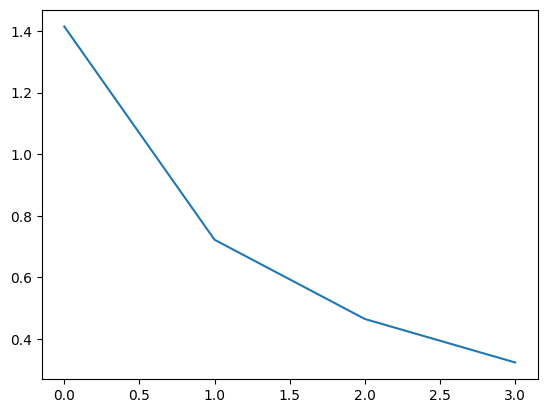

In [21]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

##### Evaluating for 20 epochs S2S without attention

In [58]:
evaluateAndShowAttention(test1, encoder, decoder,)

input = je vais a l ecole tous les jours
output = i m going to the concert next week <EOS>


In [55]:
evaluateAndShowAttention(test2, encoder, decoder,)

input = le chat dort sur le canape
output = he is the hang of the past the examination <EOS>


In [46]:
evaluateAndShowAttention(test3, encoder, decoder,)

input = il fait beau temps aujourd hui
output = he is always here for me for the job <EOS>


In [48]:
evaluateAndShowAttention(test4, encoder, decoder,)

input = j aime ecouter de la musique classique
output = i m fond of listening to classical music <EOS>


In [79]:
# evaluateAndShowAttention(test5, encoder, decoder,)

In [81]:
#  save the training loss
save_loss( "20-epochs-WO-ATT", losses)

,20-epochs-WO-ATT
0,1.414342
1,0.722249
2,0.465175
3,0.324086


##### 50 epochs

Reading lines...
Read 232736 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
11m 41s (- 105m 11s) (5 10%) 1.4214
22m 45s (- 91m 0s) (10 20%) 0.7756
33m 44s (- 78m 44s) (15 30%) 0.5178
44m 57s (- 67m 25s) (20 40%) 0.3676
55m 57s (- 55m 57s) (25 50%) 0.2729
66m 56s (- 44m 37s) (30 60%) 0.2102
77m 56s (- 33m 24s) (35 70%) 0.1666
89m 12s (- 22m 18s) (40 80%) 0.1373
100m 18s (- 11m 8s) (45 90%) 0.1159
111m 22s (- 0m 0s) (50 100%) 0.1004


<Figure size 640x480 with 0 Axes>

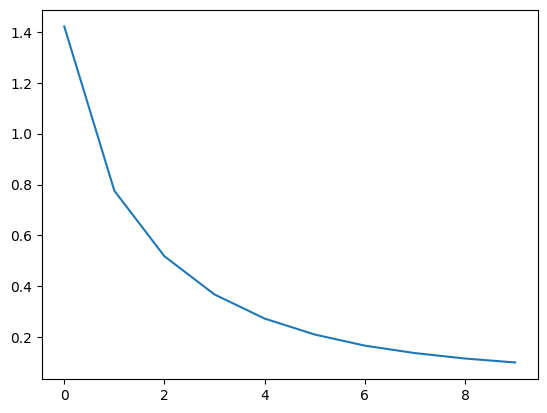

In [83]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 50, print_every=5, plot_every=5)

##### Evaluating and showing attention for 50 epochs S2S without attention

In [84]:
evaluateAndShowAttention(test1, encoder, decoder,)

input = je vais a l ecole tous les jours
output = i m going to the mountains right now <EOS>


In [85]:
evaluateAndShowAttention(test2, encoder, decoder,)

input = le chat dort sur le canape
output = she is getting her driver aren t he ? <EOS>


In [86]:
evaluateAndShowAttention(test3, encoder, decoder,)

input = il fait beau temps aujourd hui
output = he is one of your students in the dark <EOS>


In [87]:
evaluateAndShowAttention(test4, encoder, decoder,)

input = j aime ecouter de la musique classique
output = we re studying french and web design <EOS>


In [88]:
# evaluateAndShowAttention(test5, encoder, decoder,)

In [15]:
save_loss( "50-epochs-WO-ATT", losses)

,50-epochs-WO-ATT
0,1.426513
1,0.786837
2,0.554607
3,0.421170
4,0.332723
5,0.271741
6,0.226642
7,0.192991
8,0.167349
9,0.147430


#### Training S2S model with additive attention

##### 20 epochs

Reading lines...


Read 232736 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
14m 32s (- 43m 37s) (5 25%) 1.2363
28m 18s (- 28m 18s) (10 50%) 0.5024
41m 49s (- 13m 56s) (15 75%) 0.2746
55m 26s (- 0m 0s) (20 100%) 0.1755


<Figure size 640x480 with 0 Axes>

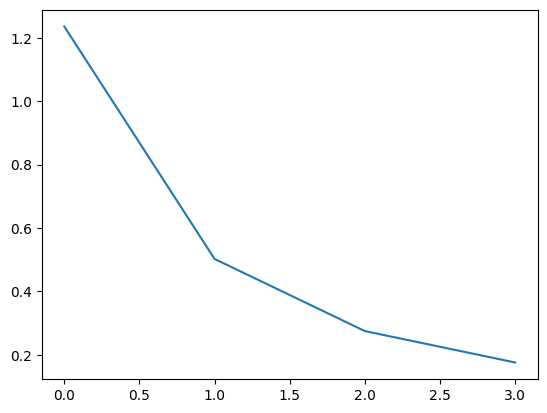

In [44]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNNBA(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

##### Evaluating and showing attension for S2S with additive attension 20 epochs

input = je vais a l ecole tous les jours
output = i m going to school on the food <EOS>


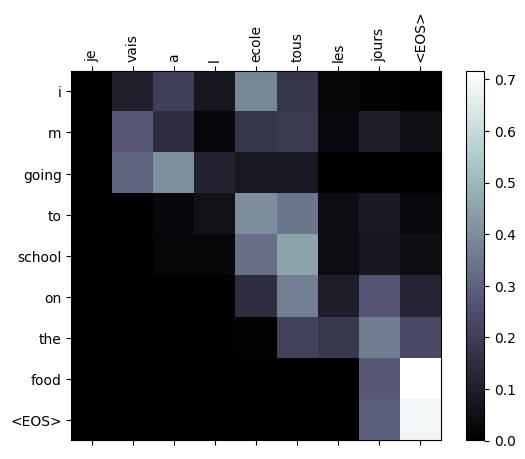

In [45]:
evaluateAndShowAttention(test1, encoder, decoder,)

input = le chat dort sur le canape
output = he is on a social at his room on the sofa <EOS>


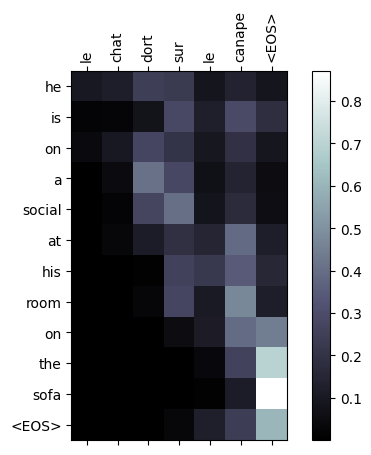

In [46]:
evaluateAndShowAttention(test2, encoder, decoder)

input = il fait beau temps aujourd hui
output = he is doing all today today <EOS>


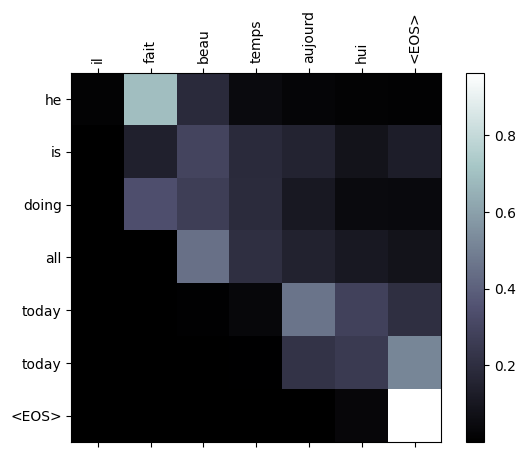

In [47]:
evaluateAndShowAttention(test3, encoder, decoder,)

input = j aime ecouter de la musique classique
output = i m fond of listening to classical music <EOS>


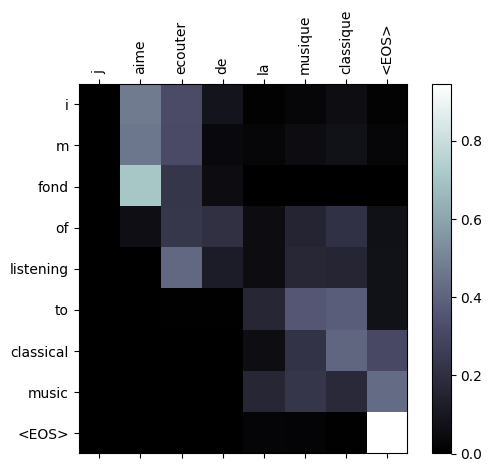

In [48]:
evaluateAndShowAttention(test4, encoder, decoder,)

In [51]:
save_loss( "20-epochs-W-BATT", losses)

,20-epochs-W-BATT
0,1.236282
1,0.502386
2,0.274622
3,0.175507


##### 50 epochs

Reading lines...
Read 232736 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
13m 25s (- 120m 50s) (5 10%) 1.2797
26m 54s (- 107m 38s) (10 20%) 0.5329
40m 34s (- 94m 41s) (15 30%) 0.2935
54m 48s (- 82m 13s) (20 40%) 0.1876
68m 51s (- 68m 51s) (25 50%) 0.1352
83m 5s (- 55m 23s) (30 60%) 0.1066
97m 5s (- 41m 36s) (35 70%) 0.0893
111m 6s (- 27m 46s) (40 80%) 0.0773
125m 28s (- 13m 56s) (45 90%) 0.0699
139m 55s (- 0m 0s) (50 100%) 0.0637


<Figure size 640x480 with 0 Axes>

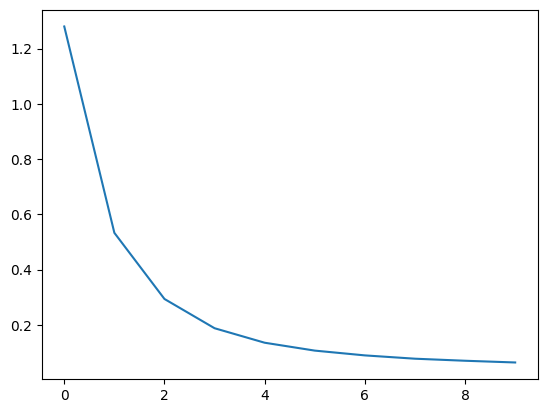

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNNBA(hidden_size, output_lang.n_words).to(device)

losess = train(train_dataloader, encoder, decoder, 50, print_every=5, plot_every=5)

##### Evaluating and showing attension for S2S with additive attension 50 epochs

input = je vais a l ecole tous les jours
output = i m going to school all order to eat <EOS>


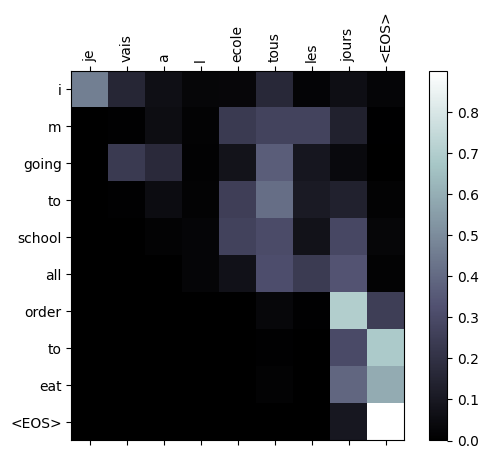

In [ ]:
evaluateAndShowAttention(test1, encoder, decoder,)

input = le chat dort sur le canape
output = you re out shopping for the word <EOS>


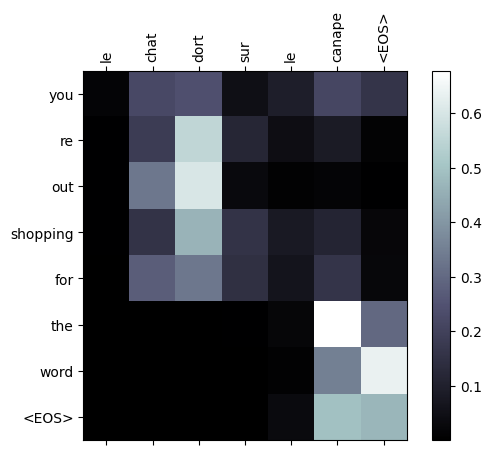

In [ ]:
evaluateAndShowAttention(test2, encoder, decoder,)

input = j aime ecouter de la musique classique
output = i am fond of listening to classical music <EOS>


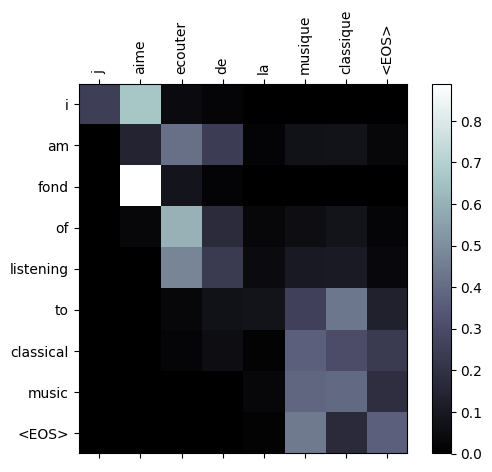

In [ ]:
evaluateAndShowAttention(test4, encoder, decoder,)

In [ ]:
save_loss( "50-epochs-W-BATT", losses)

,50-epochs-W-BATT
0,1.421445
1,0.775614
2,0.517819
3,0.367616
4,0.272909
5,0.210192
6,0.166600
7,0.137257
8,0.115884
9,0.100355


#### Training S2S model with Dot product attention

##### 20 epochs

Reading lines...
Read 232737 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
15m 25s (- 46m 16s) (5 25%) 1.3333
31m 9s (- 31m 9s) (10 50%) 0.6649
46m 27s (- 15m 29s) (15 75%) 0.4129
62m 12s (- 0m 0s) (20 100%) 0.2762


<Figure size 640x480 with 0 Axes>

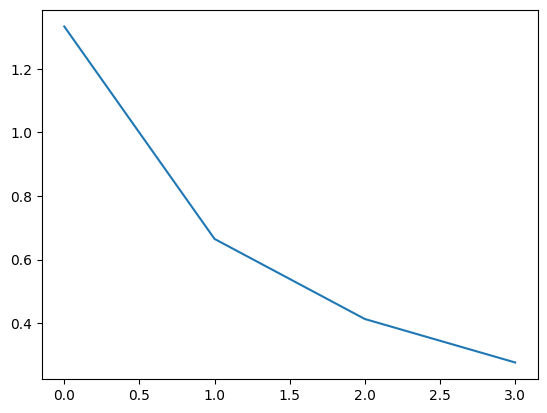

In [24]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNNLA(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

##### Evaluating and showing attension for S2S with dot product attension 20 epochs

input = je vais a l ecole tous les jours
output = i m going to the party out the whole way people <EOS>


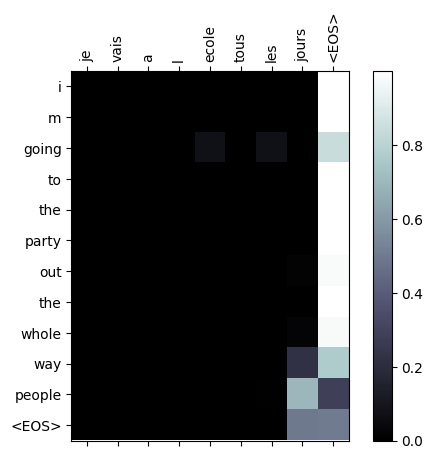

In [25]:
evaluateAndShowAttention(test1, encoder, decoder,)


input = le chat dort sur le canape
output = they re out shopping for the damage <EOS>


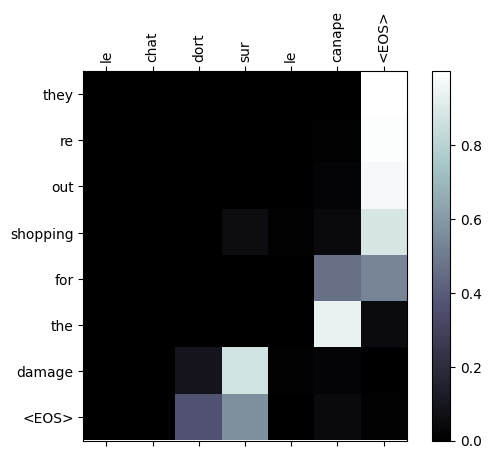

In [26]:
evaluateAndShowAttention(test2, encoder, decoder)

input = il fait beau temps aujourd hui
output = he is hard in order to leave a hotel <EOS>


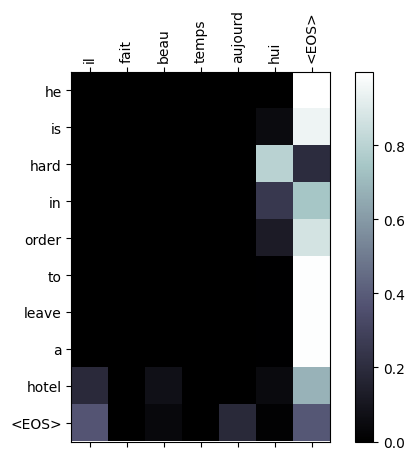

In [27]:
evaluateAndShowAttention(test3, encoder, decoder)

input = j aime ecouter de la musique classique
output = i m fond of listening to classical music <EOS>


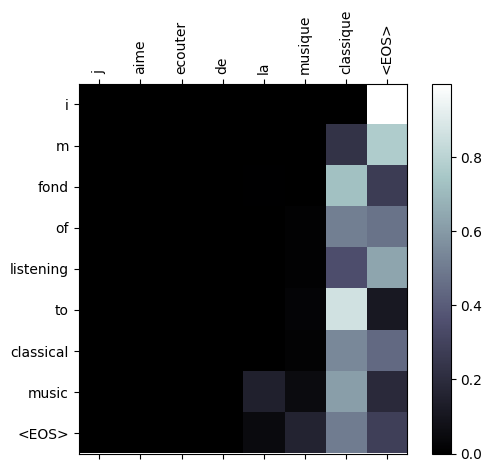

In [28]:
evaluateAndShowAttention(test4, encoder, decoder)

In [29]:
save_loss( "20-epochs-W-DPATT", losses)

,20-epochs-W-DPATT
0,1.333281
1,0.664872
2,0.412948
3,0.276219


##### 50 epochs

Reading lines...
Read 232737 sentence pairs
SAMPLE PAIR ['cc by france attribution tatoeba org cm wittydev', 'va !', 'go']
Trimmed to 20012 sentence pairs
Counting words...
Counted words:
fra 6103
eng 4004
56m 21s (- 507m 12s) (5 10%) 1.3324
69m 35s (- 278m 21s) (10 20%) 0.6782
82m 54s (- 193m 27s) (15 30%) 0.4295
96m 0s (- 144m 1s) (20 40%) 0.2931
108m 42s (- 108m 42s) (25 50%) 0.2145
122m 29s (- 81m 39s) (30 60%) 0.1656
135m 48s (- 58m 12s) (35 70%) 0.1348
148m 31s (- 37m 7s) (40 80%) 0.1142
160m 57s (- 17m 53s) (45 90%) 0.1002
173m 28s (- 0m 0s) (50 100%) 0.0894


<Figure size 640x480 with 0 Axes>

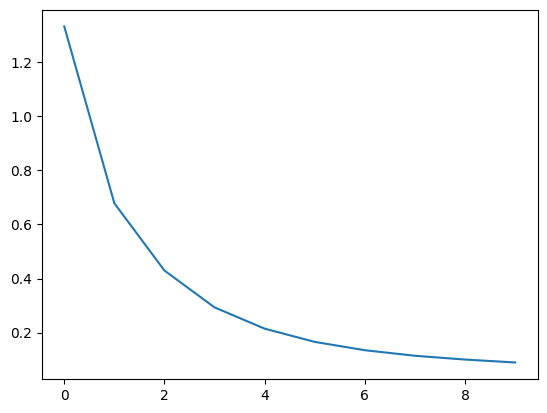

In [32]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNNLA(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 50, print_every=5, plot_every=5)

##### Evaluating and showing attension for S2S with dot product attension 20 epochs

input = je vais a l ecole tous les jours
output = i m going to the market after all night <EOS>


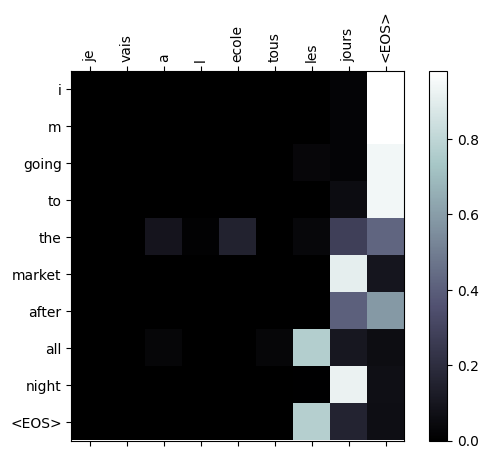

In [33]:
evaluateAndShowAttention(test1, encoder, decoder,)

input = le chat dort sur le canape
output = they re making the expensive clothes <EOS>


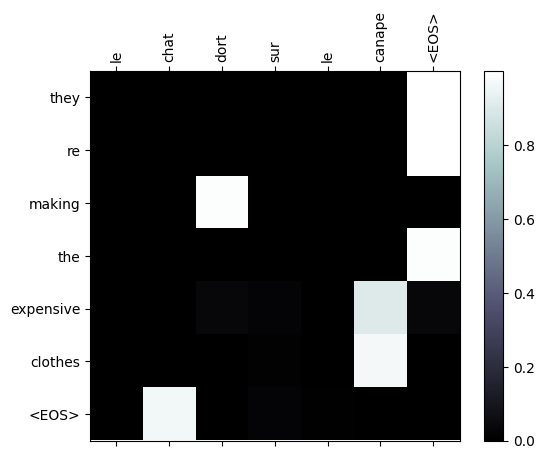

In [34]:
evaluateAndShowAttention(test2, encoder, decoder,)

input = il fait beau temps aujourd hui
output = he is putting on his parents <EOS>


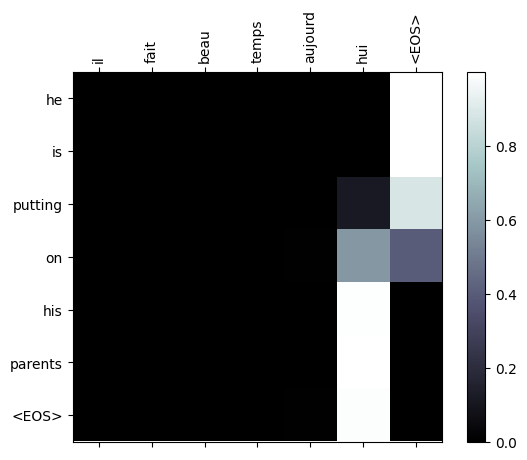

In [35]:
evaluateAndShowAttention(test3, encoder, decoder,)

input = j aime ecouter de la musique classique
output = i m fond of listening to music <EOS>


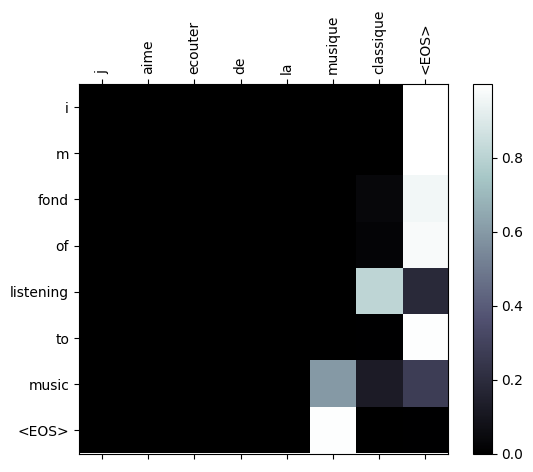

In [36]:
evaluateAndShowAttention(test4, encoder, decoder,)

In [5]:
save_loss( "50-epochs-W-DPATT", losses)

,50-epochs-W-DPATT
0,1.332366
1,0.678231
2,0.429474
3,0.293124
4,0.214533
5,0.165587
6,0.134815
7,0.114233
8,0.100241
9,0.089440


### Evaluating all sequence to sequence models

In [86]:
import os
import pandas as pd
def load_losses_df(dir):
    df_list_20 = []
    df_list_50 = []
    all_losses = os.listdir(dir)
    for loss in all_losses:
        if loss.endswith("csv"):
            if loss.startswith("20"):
                df = pd.read_csv(os.path.join(dir, loss), usecols=[loss.split(".")[0]])
                df_list_20.append(df)
            elif loss.startswith("50"):
                df = pd.read_csv(os.path.join(dir, loss), usecols=[loss.split(".")[0]])
                df_list_50.append(df)
                
    return df_list_20, df_list_50
    

In [87]:
df_list_20, df_list_50 = load_losses_df("data")

In [88]:
import matplotlib.pyplot as plt
import numpy as np
def evaluate_all_s2s(df_list, x):
    for df in df_list:
        plt.plot( np.linspace(0, x, df.shape[0]), df.iloc[:, 0], label="BahdanauAttention" if "BATT" in df.columns[0] else ("Without attention" if "WO" in df.columns[0] else "Dot attention"))
    plt.legend()

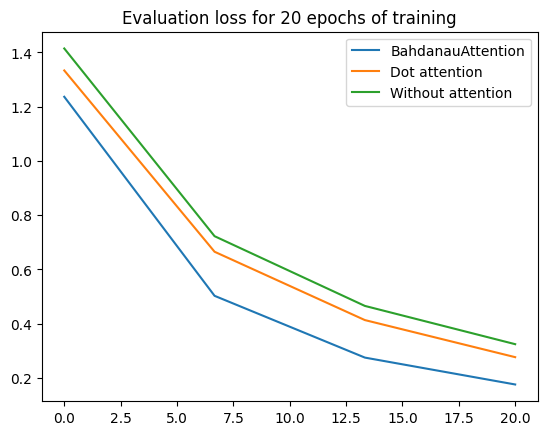

In [90]:
plt.title("Evaluation loss for 20 epochs of training")
evaluate_all_s2s(df_list_20, 20)
plt.show()

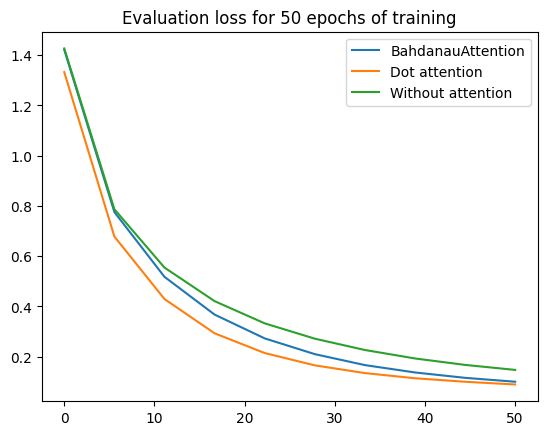

In [91]:
plt.title("Evaluation loss for 50 epochs of training")
evaluate_all_s2s(df_list_50, 50)
plt.show()